# Comparison of (sub)KKR and (sub)KBR to an Analytical Baseline

In [28]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [29]:
# enable inline plotting
%matplotlib inline
# uncomment this line to open a console with the same kernel
%qtconsole

import numpy as np
import pandas as pd

import scipy.linalg as linalg
import scipy.spatial as spatial
import scipy.stats as stats

#  RMSE
from sklearn.metrics import mean_squared_error

# heatmap
import seaborn as sns

import matplotlib.pyplot as plt

from ipywidgets import interact

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

from kkr import *

Loading BokehJS ...

## Estimation of a Gaussian distribution

In this notebook, we want to show a comparison of the (subspace) kernel Kalman rule ((sub)KKR) and the (subspace) kernel Bayes' rule ((sub)KBR) to an analytical baseline.
The idea of this comparison is the following: we get samples from a Gaussian distribution, but don't know the mean.
In the first part we assume the variance still to be known, later we want to infer the variance as well.

Using a set of training samples, we can embed a prior distribution and learn the operators for (sub)KBR and (sub)KKR.
We can use these then to iteratively infer the mean (and later the variance) of an unknow Gaussian distribution by only observing samples from it.
To compare both inference methods to a baseline, we can also do this analytically by assuming a conjugate prior and white Gaussian noise.

### Assuming the variance to be known

Let's say we have a known and constant variance of the unknown Gaussian with variance $\sigma^2 = 1/9$.
For simplicity we will work now with the precision $\lambda = 1/\sigma^2 = 9$.
According to [1], we can obtaint the posterior of the mean $\mu$ after $n$ observed samples as
\begin{align}
p(\mu|\mathcal D, \lambda) &= \mathcal N(\mu|\mu_n, \lambda_n) \\
\lambda_n &= \lambda_0 + n\lambda \\
\mu_n &= \frac{\bar x n \lambda + \mu_0\lambda_0}{\lambda_n},
\end{align}
where $\lambda_0$ and $\mu_0$ is the mean and the precision of the prior distribution over the mean $\mu$ of the unknown Gaussain, and $\bar x = 1/n \sum_i x_i$ is the sample mean.

[1] Conjugate Bayesian analysis of the Gaussian distribution, *Kevin P. Murphy*, [PDF](http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf)

### Drawing samples

The underlying process is the following:
* First, a latent context $c$ is sampled randomly from a uniform distribution in the range $[-5, 5]$.
* Then, around that context, we draw a Gaussian sample with $\mu = c$ and $\sigma = 0.3$. This is the observation.

As training data, we sample $n$ latent contexts $c_i$ and for each context a single sample from the Gaussian distribution $\mathcal N(c_i,\sigma)$ at that location.

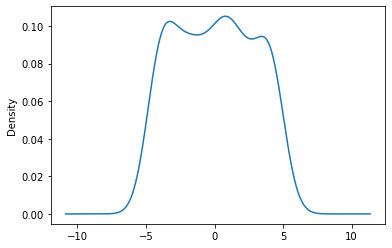

In [30]:
num_samples = 500

data = pd.DataFrame(
    np.zeros((num_samples,2)),
    columns=['context','samples']
)

data['context'] = np.random.uniform(low=-5, high=5, size=(num_samples,1))

noise_mean = 0
noise_std = 1/3
data['samples'] = np.random.normal(loc=data['context'] + noise_mean, scale=noise_std)

# kernel density estimation on the samples
ax = data['samples'].plot.kde()

To compare the methods, we sample a single test context $c^\ast$ from the same uniform distribution and then draw samples $y_i$ from the Gaussian $\mathcal N(c^\ast,\sigma)$ as observations.
From these observations we then want to infer the latent context $c^\ast$ using Bayes' rule.

In [31]:
test_context = np.random.uniform(low=-5, high=5, size=1)

groundTruthN = stats.norm(loc=test_context + noise_mean, scale=noise_std)


# draw samples
numTestSamples = 50
plotSteps = 1

testData = pd.DataFrame(
#     np.random.normal(loc=test_context + noise_mean,
#                      scale=noise_std,
#                      size=(numTestSamples)),
    groundTruthN.rvs(size=numTestSamples),
    columns=['samples']
)

# # Ground Truth
# print(test_context + noise_mean)
# testData['samples'][10] = test_context + noise_std * 4
# testData['samples'][40] = test_context - noise_std * 4

# # テストデータに外れ値を入れる
# print(testData['samples'])

### Analytical posterior estimation with conjugate prior

Although this data is obviously not Gaussian distributed, we can now simply assume a Gaussian prior on the mean of the unknown distribution and compute the mean $\mu_0$ and the variance $\sigma_0^2$.

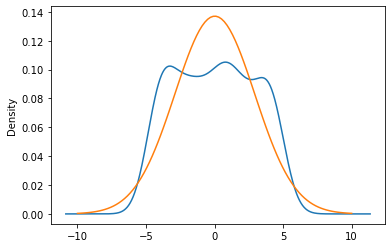

In [32]:
mu_0 = data['samples'].mean()
var_0 = data['samples'].var()
lamb_0 = 1/var_0

priorN = stats.norm(loc=mu_0, scale=data['samples'].std())

x = np.linspace(-10, 10, 100)

ax = data['samples'].plot.kde()

ax = ax.plot(x, priorN.pdf(x))

Estimate the posterior values and plot the posterior distribution for different number of samples

In [33]:
lamb = 1/noise_std**2

testData['postLambda'] = (np.array(range(numTestSamples)) + 1) * lamb + lamb_0
testData['postMu'] = (testData['samples'].cumsum() * lamb + mu_0 * lamb_0) / testData['postLambda']

### Maximum Likelihood Estimate

Computing the maximum likelihood estimate of the mean is easy.
Even more with the built-in methods of Pandas.
By using the expanding() grouping, we obtain the mean of the past to current observations for each observation.
With the standard deviation, we can compute the standard deviation of the ML estimator as
\begin{align}
    \sigma_{\mu_{ML}} = \frac{\sigma_{ML}}{\sqrt{n}}
\end{align}

In [34]:
testData['mlMu'] = testData['samples'].expanding().mean()
testData['mlStd'] = testData['samples'].expanding().std()

### Kernel Bayes' Rule

Now we can compute the kernel Bayes rule estimate of the Gaussian distribution.
First, we need to choose some hyper-parameters:

In [35]:
kernel_size = 100         # number of data points in the kernel matrices

We select the bandwiths of the kernel functions according to the median trick:

In [63]:
# bandwidths = {'context': 0, 'samples': 0}

# for k in ['context', 'samples']:
#     distances = spatial.distance.pdist(data[[k]], metric='sqeuclidean')
#     bandwidths[k] = np.sqrt(np.median(distances))

# bandwidth_factor_k = np.exp(.0)    # bandwidth factor of the kernel function k
# bandwidth_factor_g = np.exp(.0)    # bandwidth factor of the kernel function g

# bandwidth_k = bandwidth_factor_k * bandwidths['context']
# bandwidth_g = bandwidth_factor_g * bandwidths['samples']

2.918164982586196
0     -3.532937
1      0.160291
2     -0.069046
3     -3.117342
4      4.829701
         ...   
495    3.654664
496    4.319354
497   -0.930958
498   -3.746183
499    2.226779
Name: context, Length: 500, dtype: float64


Select a random subset of the training data for learning the kernel Kalman rule

In [37]:
reference_set = data[['context', 'samples']].sample(n=kernel_size)#.sort_index()

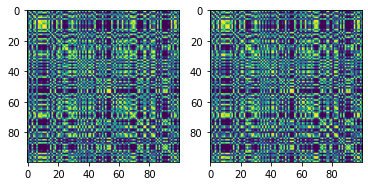

In [38]:
kernel_k = ExponentialQuadraticKernel()
kernel_k.bandwidth = bandwidth_k
kernel_k.normalized = True

K = kernel_k(reference_set[['context']].values)

kernel_g = ExponentialQuadraticKernel()
kernel_g.bandwidth = bandwidth_g

G = kernel_g(reference_set[['samples']].values)
k_g = lambda y: kernel_g(reference_set[['samples']].values, y)

X = reference_set[['samples']].values

f, axs = plt.subplots(1,2)
_= axs[0].imshow(K)
_= axs[1].imshow(G)

We can compute some matrices before the iterative update of the mean estimate and embed the prior distribution over all training samples

In [39]:
# C = linalg.solve(K + alpha1 * np.eye(kernel_size), K, assume_a='pos')

# K_all = kernel_k(reference_set[['context']].values,
#                                data[['context']].values)
# C_0 = linalg.solve(K + alpha1 * np.eye(kernel_size), K_all, assume_a='pos')

# m_0 = np.mean(C_0, axis=1, keepdims=True)

# _ = plt.plot(m_0, '.')

### KBR(a)

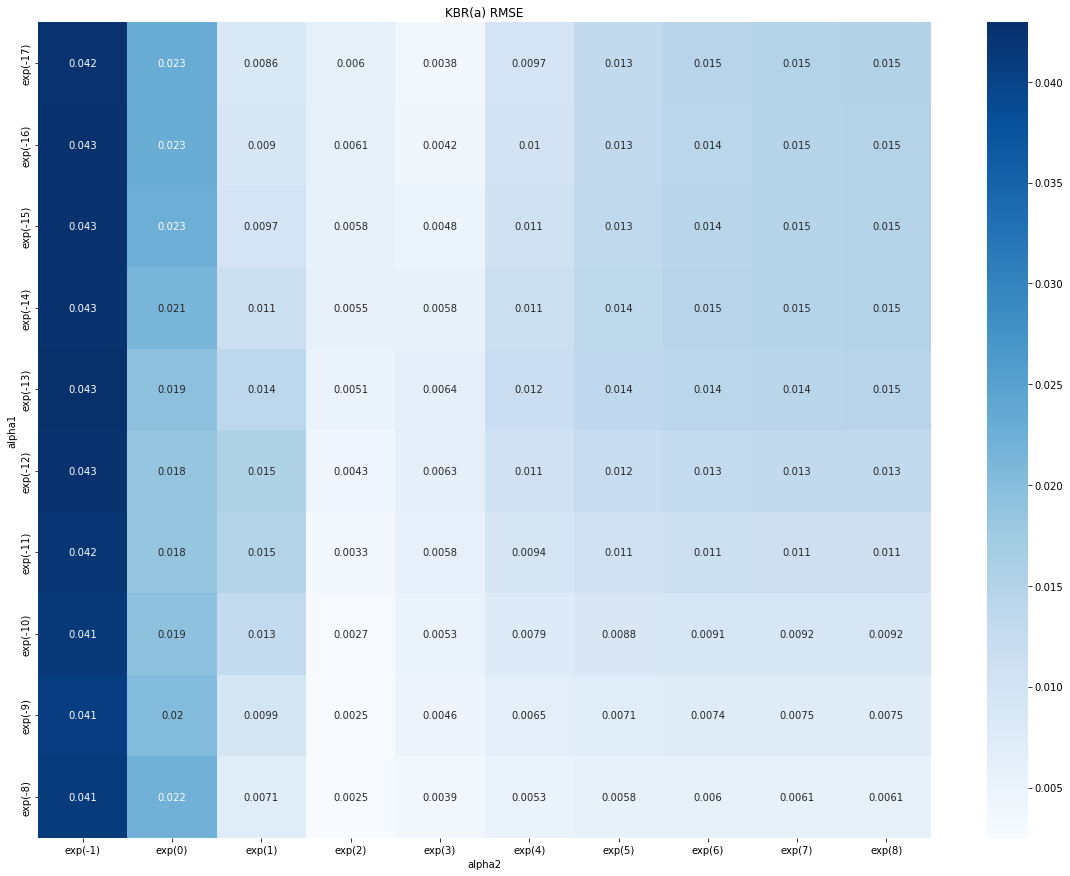

In [40]:
# regularization parameter for the inverses
alphas1_KBRa = [np.exp(i) for i in range(-17, -7)]
alphas1_labels_KBRa= ['exp({0})'.format(i) for i in range(-17, -7)]
alphas2_KBRa = [np.exp(i) for i in range(-1, 9)] 
alphas2_labels_KBRa= ['exp({0})'.format(i) for i in range(-1, 9)]


RMSE_KBRa = []
min_RMSE_KBRa = 1e9
best_kbraMu = []

for alpha1 in alphas1_KBRa:
    # 平均値を更新する前に事前計算する
    C = linalg.solve(K + alpha1 * np.eye(kernel_size), K, assume_a='pos')

    K_all = kernel_k(reference_set[['context']].values,
                                   data[['context']].values)
    C_0 = linalg.solve(K + alpha1 * np.eye(kernel_size), K_all, assume_a='pos')

    m_0 = np.mean(C_0, axis=1, keepdims=True)

    for alpha2 in alphas2_KBRa:
        m_a = m_0.copy()

        for i in range(numTestSamples):
            # embed observation
            y = testData.loc[i, 'samples'].reshape((-1,1))
            g_y = k_g(y)

            # perform Bayes update according to KBR(a)
            L_a = C.dot(np.diag(m_a.flat))
            D_a = np.diag(C.dot(m_a).flat)
            D_aG = D_a.dot(G)

            m_a = L_a.T.dot(linalg.solve(D_aG.dot(D_aG) + alpha2 * np.eye(kernel_size), G)).dot(D_a).dot(g_y)
            #normalization
            m_a = m_a / m_a.sum(axis=0)

            # project into state space
            testData.loc[i, 'kbraMu'] = X.T.dot(C.dot(m_a))[0][0]
        
        rmse = mean_squared_error(testData['postMu'], testData['kbraMu'])
        RMSE_KBRa.append(rmse)
        if rmse < min_RMSE_KBRa:
            best_kbraMu = testData['kbraMu']

#  plot RMSE heatmap
plt.figure(figsize=(20,15))
plt.title("KBR(a) RMSE")
df_KBRa = pd.DataFrame(data=np.array(RMSE_KBRa).reshape((len(alphas1_KBRa), len(alphas2_KBRa))), index=alphas1_labels_KBRa, columns=alphas2_labels_KBRa)
s = sns.heatmap(df_KBRa, annot=True, cmap='Blues')
s.set(xlabel='alpha2', ylabel='alpha1')

# best kbraMu
testData['kbraMu'] = best_kbraMu

### KBR(b)

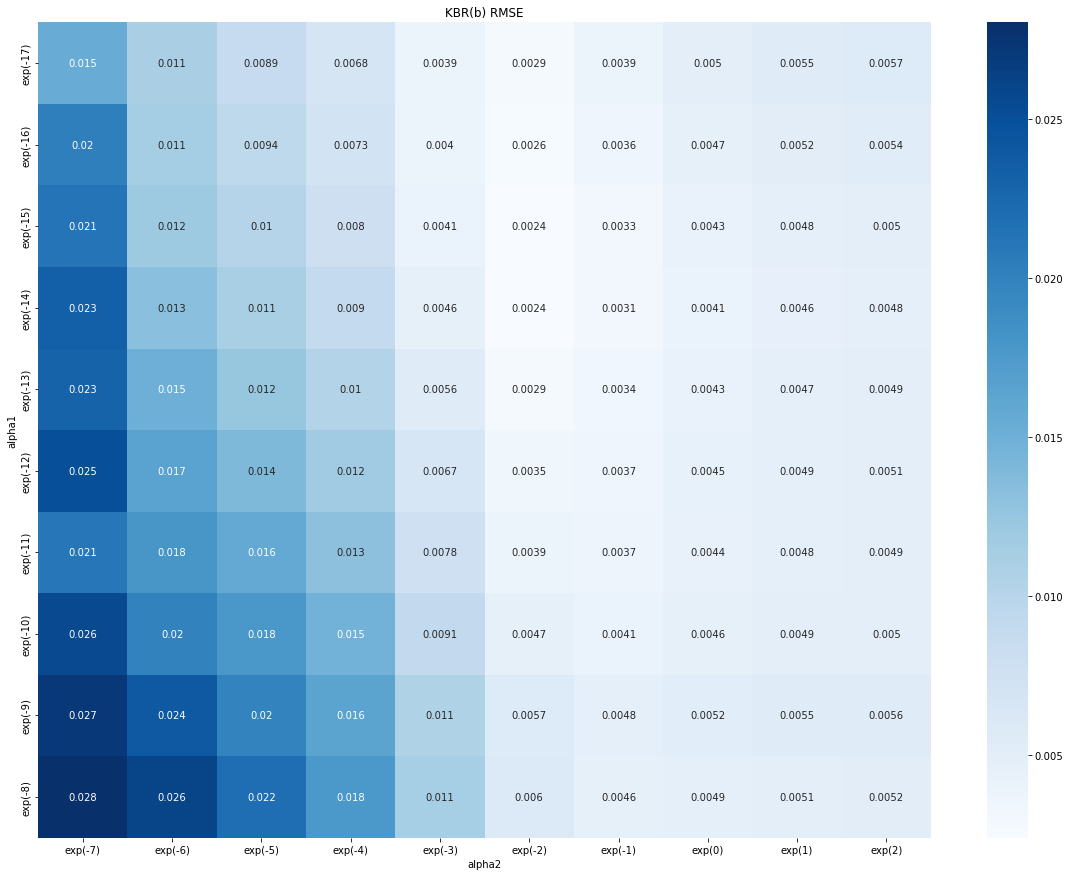

In [41]:
# KBRb
alphas1_KBRb = [np.exp(i) for i in range(-17, -7)]
alphas1_labels_KBRb= ['exp({0})'.format(i) for i in range(-17, -7)]
alphas2_KBRb = [np.exp(i) for i in range(-7, 3)] 
alphas2_labels_KBRb= ['exp({0})'.format(i) for i in range(-7, 3)]

RMSE_KBRb = []
min_RMSE_KBRb= 1e9
best_kbrbMu = []

for alpha1 in alphas1_KBRb:
    # 平均値を更新する前に事前計算する
    C = linalg.solve(K + alpha1 * np.eye(kernel_size), K, assume_a='pos')

    K_all = kernel_k(reference_set[['context']].values,
                                   data[['context']].values)
    C_0 = linalg.solve(K + alpha1 * np.eye(kernel_size), K_all, assume_a='pos')

    m_0 = np.mean(C_0, axis=1, keepdims=True)

    for alpha2 in alphas2_KBRb:
        m_b = m_0.copy()

        for i in range(numTestSamples):
            # embed observation
            y = testData.loc[i, 'samples'].reshape((-1,1))
            g_y = k_g(y)

            # perform Bayes update according to KBR(b)
            D_b = np.diag(C.dot(m_b).flat)
            D_bG = D_b.dot(G)

            m_b = D_bG.dot(linalg.solve(D_bG.dot(D_bG) + alpha2 * np.eye(kernel_size), D_b)).dot(g_y)
            # normalization
            m_b = m_b / m_b.sum(axis=0)

            # project into state space
            testData.loc[i,'kbrbMu'] = X.T.dot(C.dot(m_b))[0][0]
        
        rmse = mean_squared_error(testData['postMu'], testData['kbrbMu'])
        RMSE_KBRb.append(rmse)
        if rmse < min_RMSE_KBRb:
            best_kbrbMu = testData['kbrbMu']

#  plot RMSE heatmap
plt.figure(figsize=(20,15))
plt.title("KBR(b) RMSE")
df_KBRb = pd.DataFrame(data=np.array(RMSE_KBRb).reshape((len(alphas1_KBRb), len(alphas2_KBRb))), index=alphas1_labels_KBRb, columns=alphas2_labels_KBRb)
s = sns.heatmap(df_KBRb, annot=True, cmap='Blues')
s.set(xlabel='alpha2', ylabel='alpha1')

# best kbrbMu
testData['kbrbMu'] = best_kbrbMu

### KBR(c)

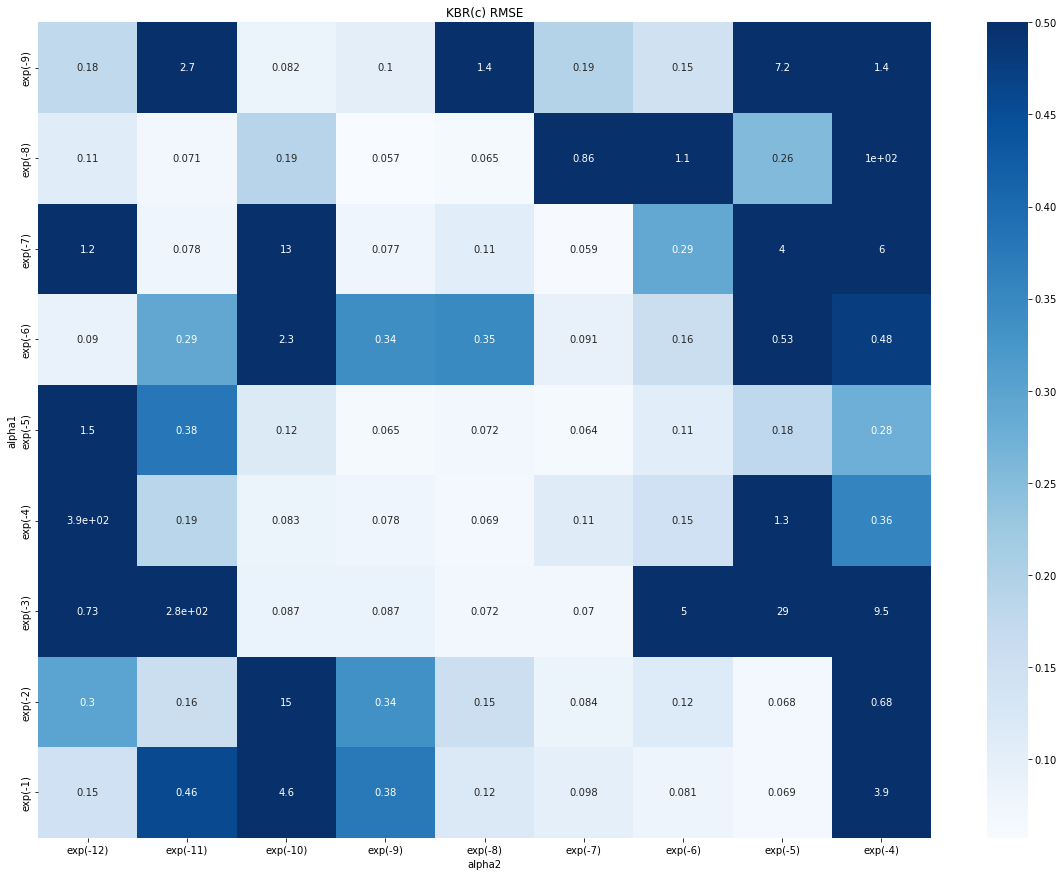

In [42]:
# KBRc
alphas1_KBRc = [np.exp(i) for i in range(-9, 0)]
alphas1_labels_KBRc= ['exp({0})'.format(i) for i in range(-9, 0)]
alphas2_KBRc = [np.exp(i) for i in range(-12, -3)] 
alphas2_labels_KBRc= ['exp({0})'.format(i) for i in range(-12, -3)]

RMSE_KBRc = []
min_RMSE_KBRc= 1e9
best_kbrcMu = []

for alpha1 in alphas1_KBRc:
    # 平均値を更新する前に事前計算する
    C = linalg.solve(K + alpha1 * np.eye(kernel_size), K, assume_a='pos')

    K_all = kernel_k(reference_set[['context']].values,
                                   data[['context']].values)
    C_0 = linalg.solve(K + alpha1 * np.eye(kernel_size), K_all, assume_a='pos')

    m_0 = np.mean(C_0, axis=1, keepdims=True)

    for alpha2 in alphas2_KBRc:
        m_c = m_0.copy()

        for i in range(numTestSamples):
            # embed observation
            y = testData.loc[i, 'samples'].reshape((-1,1))
            g_y = k_g(y)

            # perform Bayes update according to KBR(c)
            D_c = np.diag(C.dot(m_c).flat)
            D_cG = D_c.dot(G)

            m_c = linalg.solve(D_cG + alpha2 * np.eye(kernel_size), D_c).dot(g_y)
            # normalization
            m_c = m_c / m_c.sum(axis=0)

            # project into state space
            testData.loc[i,'kbrcMu'] = X.T.dot(C.dot(m_c))[0][0]

        rmse = mean_squared_error(testData['postMu'], testData['kbrcMu'])
        RMSE_KBRc.append(rmse)
        if rmse < min_RMSE_KBRc:
            best_kbrcMu = testData['kbrcMu']

#  plot RMSE heatmap
plt.figure(figsize=(20,15))
plt.title("KBR(c) RMSE")
df_KBRc = pd.DataFrame(data=np.array(RMSE_KBRc).reshape((len(alphas1_KBRc), len(alphas2_KBRc))), index=alphas1_labels_KBRc, columns=alphas2_labels_KBRc)
s = sns.heatmap(df_KBRc, annot=True, cmap='Blues', vmax=0.5)
s.set(xlabel='alpha2', ylabel='alpha1')

# best kbrcMu
testData['kbrcMu'] = best_kbrcMu

### Subspace Kernel Bayes' Rule

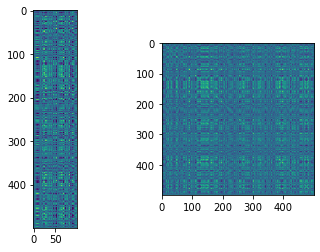

In [43]:
large_kernel_size = num_samples
# alpha1 = np.exp(-5)      # regularization parameter for the inverses
# alpha2 = np.exp(-5)

K_r = kernel_k(data[['context']].values, reference_set[['context']].values)

G = kernel_g(data[['context']].values)
k_g = lambda y: kernel_g(data[['context']].values, y)

f, axs = plt.subplots(1,2)
_= axs[0].imshow(K_r)
_= axs[1].imshow(G)

In [44]:
# # since we use all available training samples to represent the state, the initial weights
# # is just a vector with all 1/n
# m_0 = np.ones(large_kernel_size) / large_kernel_size

# C = np.linalg.solve(K_r.T.dot(K_r) + alpha1 * np.eye(kernel_size), K_r.T)
# E = K_r.T.dot(G).dot(K_r)

In [45]:
alphas1_subKBR = [np.exp(i) for i in range(-10, 0)]
alphas1_labels_subKBR= ['exp({0})'.format(i) for i in range(-10, 0)]
alphas2_subKBR = [np.exp(i) for i in range(-10, 0)] 
alphas2_labels_subKBR= ['exp({0})'.format(i) for i in range(-10, 0)]

RMSE_subKBR = []
min_RMSE_subKBR = 1e9
best_subkbrMu = []

for alpha1 in alphas1_subKBR:
    # since we use all available training samples to represent the state, the initial weights
    # is just a vector with all 1/n
    m_0 = np.ones(large_kernel_size) / large_kernel_size

    C = np.linalg.solve(K_r.T.dot(K_r) + alpha1 * np.eye(kernel_size), K_r.T)
    E = K_r.T.dot(G).dot(K_r)
    
    for alpha2 in alphas2_subKBR:
        m = m_0.copy()

        for i in range(numTestSamples):
            # embed observation
            y = testData.loc[i, 'samples'].reshape((-1,1))
            g_y = k_g(y)

            # perform Bayes update according to subKBR
            L = np.diag(m.flat).dot(C.T)
            D = C.dot(L)
            DE = D.dot(E)
            DKg = D.dot(K_r.T).dot(g_y)

            m = L.dot(E).dot(np.linalg.solve(DE.dot(DE) + alpha2 * np.eye(kernel_size), DKg))
            #normalization
            m = m / m.sum(axis=0)

            # project into state space
            testData.loc[i, 'subkbrMu'] = X.T.dot(C.dot(m))[0][0]

        rmse = mean_squared_error(testData['postMu'], testData['subkbrMu'])
        RMSE_subKBR.append(rmse)
        if rmse < min_RMSE_subKBR:
            best_subkbrMu = testData['subkbrMu']

#  plot RMSE heatmap
plt.figure(figsize=(20,15))
plt.title("subKBR RMSE")
df_subKBR = pd.DataFrame(data=np.array(RMSE_subKBR).reshape((len(alphas1_subKBR), len(alphas2_subKBR))), index=alphas1_labels_subKBR, columns=alphas2_labels_subKBR)
s = sns.heatmap(df_subKBR, annot=True, cmap='Blues')
s.set(xlabel='alpha2', ylabel='alpha1')

# best subKBRMu
testData['subkbrMu'] = best_subkbrMu

### Kernel Kalman Rule

For the kernel Kalman rule, we start again with choosing some hyper-parameters:

In [54]:
kernel_size = 100         # number of data points in the kernel matrices
# alphaO = np.exp(-10)      # regularization parameter for the inverses
# alphaQ = np.exp(-10)

Select the bandwidth according to the median trick

In [55]:
bandwidths = {'context': 0, 'samples': 0}

for k in ['context', 'samples']:
    distances = spatial.distance.pdist(data[[k]], metric='sqeuclidean')
    bandwidths[k] = np.sqrt(np.median(distances))

bandwidth_factor_k = np.exp(.0)    # bandwidth factor of the kernel function k
bandwidth_factor_g = np.exp(.0)    # bandwidth factor of the kernel function g

bandwidth_k = bandwidth_factor_k * bandwidths['context']
bandwidth_g = bandwidth_factor_g * bandwidths['samples']

Select a random subset of the training data for learning the kernel Kalman rule

In [56]:
reference_set = data[['context', 'samples']].sample(n=kernel_size)#.sort_index()

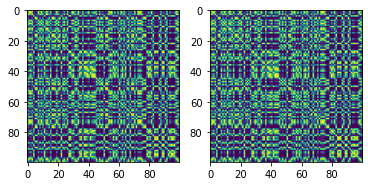

In [57]:
kernel_k = ExponentialQuadraticKernel()
kernel_k.bandwidth = bandwidth_k
kernel_k.normalized = True

K = kernel_k(reference_set[['context']].values)

kernel_g = ExponentialQuadraticKernel()
kernel_g.bandwidth = bandwidth_g

G = kernel_g(reference_set[['samples']].values)
k_g = lambda y: kernel_g(reference_set[['samples']].values, y)

f, axs = plt.subplots(1,2)
_= axs[0].imshow(K)
_= axs[1].imshow(G)

Compute the conditional operator from the context Hilbert space to the observation Hilbert space

In [58]:
# O = linalg.solve(K + alphaO * np.eye(kernel_size), K, assume_a='pos')
# X = reference_set[['samples']].values

# _r = O - np.eye(kernel_size)
# R = (_r.dot(_r.T)) / kernel_size

# f, axs = plt.subplots(1,2, sharey='all')
# f.set_figwidth(2*f.get_figheight())
# _= axs[0].imshow(O)
# _= axs[1].imshow(R)

From the training data we can now embed the prior distribution

In [59]:
# K_all = kernel_k(reference_set[['context']].values,
#                                data[['context']].values)
# C_0 = linalg.solve(K + alphaO * np.eye(kernel_size), K_all, assume_a='pos')

# m_0 = np.mean(C_0, axis=1, keepdims=True)
# S_0 = np.cov(C_0)

# # normalization
# S_0 = 0.5 * (S_0 + S_0.T)
# [eig_v, eig_r] = linalg.eigh(S_0)
# eig_v[eig_v < 1e-16*eig_v.max()] = 1e-16*eig_v.max()
# S_0 = eig_r.dot(np.diag(eig_v)).dot(eig_r.T)

# # plotting
# f, axs = plt.subplots(1,2)
# f.set_figwidth(2*f.get_figheight())
# _ = axs[0].plot(m_0, '.')
# _ = axs[1].imshow(S_0)

With this we can now iteratively apply the kernel Kalman rule to get the posterior estimates of the mean for each time step

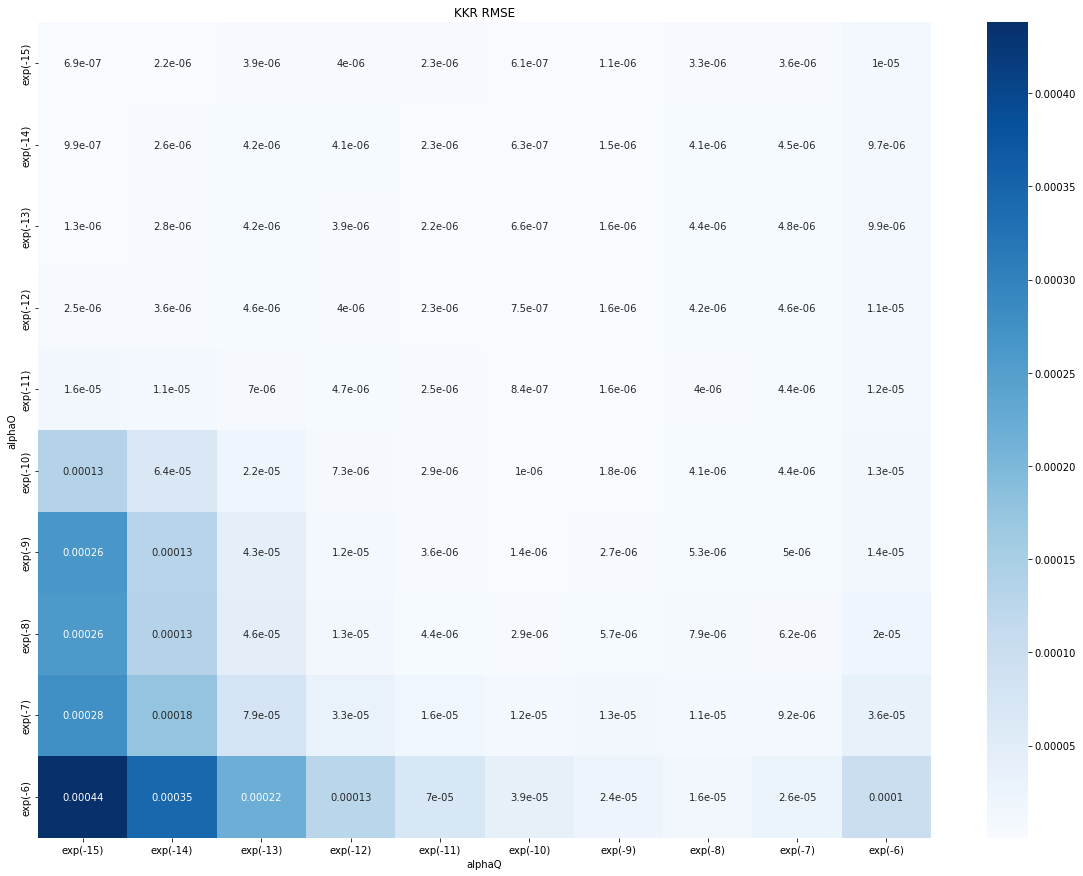

In [60]:
alphasO = [np.exp(i) for i in range(-15, -5)]
alphasO_labels= ['exp({0})'.format(i) for i in range(-15, -5)]
alphasQ = [np.exp(i) for i in range(-15, -5)] 
alphasQ_labels= ['exp({0})'.format(i) for i in range(-15, -5)]

RMSE_KKR = []
min_RMSE_KKR= 1e9
best_kkrMu = []

for alphaO in alphasO:
    # Compute the conditional operator from the context Hilbert space to the observation Hilbert space
    O = linalg.solve(K + alphaO * np.eye(kernel_size), K, assume_a='pos')
    X = reference_set[['samples']].values

    _r = O - np.eye(kernel_size)
    R = (_r.dot(_r.T)) / kernel_size

    # From the training data we can now embed the prior distribution
    K_all = kernel_k(reference_set[['context']].values,
                                   data[['context']].values)
    C_0 = linalg.solve(K + alphaO * np.eye(kernel_size), K_all, assume_a='pos')

    m_0 = np.mean(C_0, axis=1, keepdims=True)
    S_0 = np.cov(C_0)

    # normalization
    S_0 = 0.5 * (S_0 + S_0.T)
    [eig_v, eig_r] = linalg.eigh(S_0)
    eig_v[eig_v < 1e-16*eig_v.max()] = 1e-16*eig_v.max()
    S_0 = eig_r.dot(np.diag(eig_v)).dot(eig_r.T)

    for alphaQ in alphasQ:
        # initialize belief states
        m = m_0.copy()
        S = S_0.copy()

        for i in range(numTestSamples):
            # embed observation
            y = testData.loc[i, 'samples'].reshape((-1,1))
            g_y = k_g(y)

            # compute kernel Kalman gain
            Q_nominator_T = O.dot(S.T)
            Q_denominator_T = (O.dot(S).dot(O.T) + R).dot(G) + alphaQ * np.eye(kernel_size)
        #     Q_denominator_T = O.dot(S).dot(O.T).dot(G) + alphaQ * np.eye(kernel_size)
            Q = linalg.solve(Q_denominator_T, Q_nominator_T, overwrite_a=True, overwrite_b=True).T

            # perform Kalman update
            m = m + Q.dot(g_y - G.dot(O).dot(m))
            S = S - Q.dot(G).dot(O).dot(S)

            # normalization
            S = 0.5 * (S + S.T)
            [eig_v, eig_r] = linalg.eigh(S)
            eig_v[eig_v < 1e-16*eig_v.max()] = 1e-16*eig_v.max()
            S = eig_r.dot(np.diag(eig_v)).dot(eig_r.T)

            m = m / m.sum(axis=0)

            # project into state space
            testData.loc[i,'kkrMu'] = X.T.dot(O.dot(m))[0][0]
            testData.loc[i,'kkrVar'] = X.T.dot(O.dot(S).dot(O.T)).dot(X)[0][0]
        #     testData.loc[i,'kkrMAP'] =
        rmse = mean_squared_error(testData['postMu'], testData['kkrMu'])
        RMSE_KKR.append(rmse)
        if rmse < min_RMSE_KKR:
            best_kkrMu = testData['kkrMu']

#  plot RMSE heatmap
plt.figure(figsize=(20,15))
plt.title("KKR RMSE")
df_KKR = pd.DataFrame(data=np.array(RMSE_KKR).reshape((len(alphasO), len(alphasQ))), index=alphasO_labels, columns=alphasQ_labels)
s = sns.heatmap(df_KKR, annot=True, cmap='Blues')
s.set(xlabel='alphaQ', ylabel='alphaO')

# best subkbrMu
testData['kkrMu'] = best_kkrMu

### Subspace Kernel Kalman Rule

#### Plotting the Posterior Distributions

In [61]:
# plotting
plotXMin = groundTruthN.ppf(.001)[0]
# plotXMin = -0.7
plotXMax = groundTruthN.ppf(.999)[0]
# plotXMax = 0.7

x = np.arange(plotXMin,plotXMax,0.01)

p = figure(title="estimation of mean",
           plot_height=400, plot_width=800, x_range=(plotXMin,plotXMax), y_range=(0,10))

# add ground truth
gt_ray = p.ray(test_context, 0,
               length=1, angle=np.pi/2,
               line_width=2, line_color="black",
               legend="ground-truth")
post_line = p.line(x,
                   stats.norm.pdf(x,
                            loc=testData.loc[numTestSamples-1, 'postMu'],
                            scale=np.sqrt(1/testData.loc[0, 'postLambda'])),
                   line_width=2,  line_dash="dashed", line_color="black",
                   legend="posterior")
map_line = p.line([testData.loc[numTestSamples-1, 'postMu']]*2, [0, 10],
                  line_width=2,  line_dash="dashed", line_color="black",
                  legend="maximum a-posteriori")
ml_line = p.line([testData.loc[numTestSamples-1, 'mlMu']]*2, [0, 10],
                 line_width=2, line_color="#672E3B",
                 legend="maximum likelihood")
kkr_fit_line = p.line(x,
                      stats.norm.pdf(x,
                                     loc=testData.loc[numTestSamples-1, 'kkrMu'],
                                     scale=np.sqrt(testData.loc[0, 'kkrVar'])),
                      line_width=2, line_color="red",
                      legend="KKR (RBF kernel)")
kkr_exp_line = p.line([testData.loc[numTestSamples-1, 'kkrMu']]*2, [0, 10],
                 line_width=2, line_color="red",
                 legend="KKR (RBF kernel) expectation")
# kkrRQ_exp_line = p.line([testData.loc[numTestSamples-1, 'kkrRQMu']]*2, [0, 10],
#                  line_width=2, line_color="orange",
#                  legend="KKR (RQ kernel)")
kbra_exp_line = p.line([testData.loc[numTestSamples-1, 'kbraMu']]*2, [0, 10],
                 line_width=2, line_color="#4F84C4", line_dash="solid",
                 legend="KBR(a) expectation")
kbrb_exp_line = p.line([testData.loc[numTestSamples-1, 'kbrbMu']]*2, [0, 10],
                 line_width=2, line_color="#4F84C4", line_dash="dashed",
                 legend="KBR(b) expectation")
kbrc_exp_line = p.line([testData.loc[numTestSamples-1, 'kbrcMu']]*2, [0, 10],
                 line_width=2, line_color="#4F84C4", line_dash="dotted",
                 legend="KBR(c) expectation")
subkbrc_exp_line = p.line([testData.loc[numTestSamples-1, 'subkbrMu']]*2, [0, 10],
                 line_width=2, line_color="#844FC4", line_dash="solid",
                 legend="subKBR expectation")


samples_scatter = p.scatter(testData.loc[numTestSamples-1:numTestSamples-1, 'samples'],0.2, color="orange", size=5)

h = show(p, notebook_handle=True)

@interact(n=(1,numTestSamples,plotSteps))
def update_posterior_plot(n=1):
    _d = testData.loc[n-1]
    post_line.data_source.data['y'] = stats.norm.pdf(x,
                                             loc=_d.loc['postMu'],
                                             scale=np.sqrt(1/_d.loc['postLambda']))
    map_line.data_source.data['x'] = 2*[_d.loc['postMu']]
    ml_line.data_source.data['x'] = 2*[_d.loc['mlMu']]
    
    kkr_fit_line.data_source.data['y'] = stats.norm.pdf(x,
                                                loc=_d.loc['kkrMu'],
                                                scale=np.sqrt(_d.loc['kkrVar']))
    kkr_exp_line.data_source.data['x'] = 2*[_d.loc['kkrMu']]
    kbra_exp_line.data_source.data['x'] = 2*[_d.loc['kbraMu']]
    kbrb_exp_line.data_source.data['x'] = 2*[_d.loc['kbrbMu']]
    kbrc_exp_line.data_source.data['x'] = 2*[_d.loc['kbrcMu']]
    subkbrc_exp_line.data_source.data['x'] = 2*[_d.loc['subkbrMu']]
    
    samples_scatter.data_source.data['x'] = testData.loc[0:n-1, 'samples'].values
    push_notebook(handle=h)

interactive(children=(IntSlider(value=1, description='n', max=50, min=1), Output()), _dom_classes=('widget-int…

Plotting the predictive distributions

In [ ]:
p = figure(title="predictive distributions",
           plot_height=400, plot_width=800, x_range=(plotXMin,plotXMax), y_range=(0,10))

# add ground truth
gt_line = p.line(x, 
               groundTruthN.pdf(x),
               line_width=2, line_dash="dashed", line_color="gray",
               legend="ground truth")
post_line = p.line(x,
                   stats.norm.pdf(x,
                            loc=testData.loc[0, 'postMu'],
                            scale=np.sqrt(1/testData.loc[0, 'postLambda'] + noise_std**2)),
                   line_color="blue",
                   legend="posterior"
                  )
ml_line = p.line(x,
                 stats.norm.pdf(x,
                          loc=testData.loc[1, 'mlMu'],
                          scale=noise_std),
                 line_color="red",
                 legend="maximum likelihood"
                )
samples_scatter = p.scatter(testData.loc[0:0, 'samples'],0.2, color="orange")

h_predictive = show(p, notebook_handle=True)

@interact(n=(1,numTestSamples,plotSteps))
def update_predictive_plot(n=1):
    post_line.data_source.data['y'] = stats.norm.pdf(x,
                                               loc=testData.loc[n-1, 'postMu'],
                                               scale=np.sqrt(1/testData.loc[n-1, 'postLambda'] + noise_std**2))
    ml_line.data_source.data['y'] = stats.norm.pdf(x,
                                             loc=testData.loc[n-1, 'mlMu'],
                                             scale=noise_std)
    samples_scatter.data_source.data['x'] = testData.loc[0:n-1, 'samples'].values
    push_notebook(handle=h_predictive)